### A noisy detector.

***Tasks***

1. You're observing a [Cepheid](https://en.wikipedia.org/wiki/Cepheid_variable) variable star, which is a source with an intrinsic (and presumably smooth) variability.  
2. Measure its period (that's crucial for [cosmology](https://en.wikipedia.org/wiki/Hubble%27s_law)!)
3. Estimate the error on your measurement.

(When detecting a signal, state-of-the-art gravitational-wave analysis make use of another tecnique called [matched filtering](https://en.wikipedia.org/wiki/Matched_filter) which, unfortunately, we do not have time to cover here. But PCA is used to classify instrumental artifacts, see e.g. [Powell et al 2005](https://arxiv.org/abs/1505.01299)).

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.stats as stats
import sklearn
from tqdm import tqdm
import emcee
import corner
from sklearn.decomposition import FastICA
from scipy.optimize import curve_fit
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
import scipy
from scipy.optimize import fmin_cobyla
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
from sklearn.model_selection import GridSearchCV

plt.rcParams['font.size']=16 
plt.rcParams['font.family']='Liberation Serif' 
plt.rcParams['figure.autolayout']=True 
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.figsize']=(10,6)

T_true = 3.3

(2000, 3)


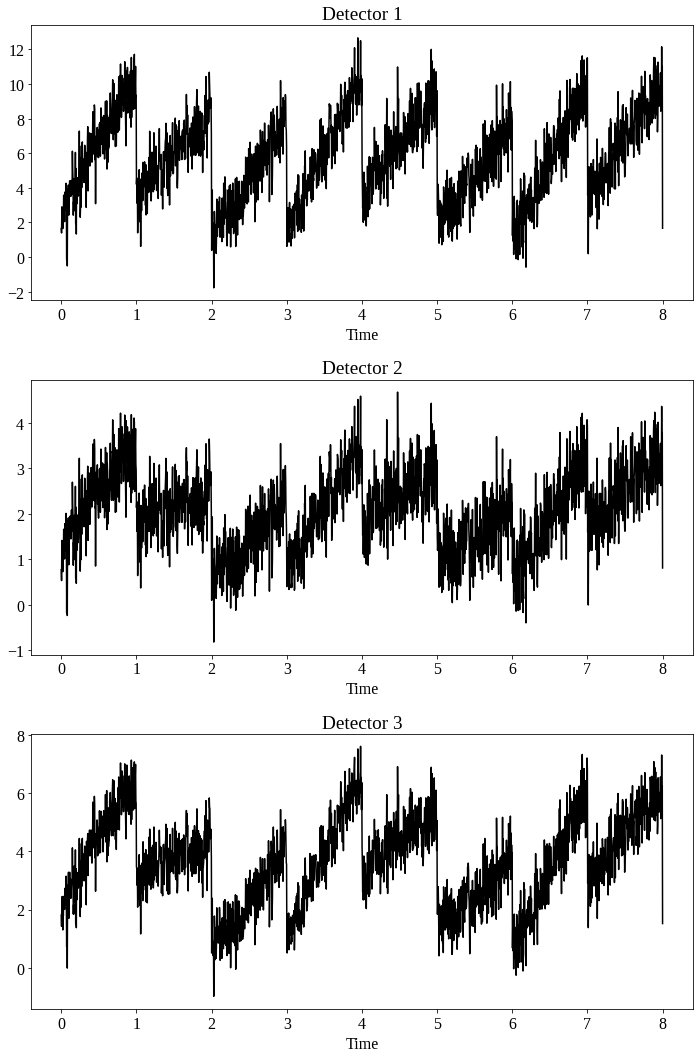

In [3]:
X=np.load('noisydetector.npy')

time = np.linspace(0, 8, X.shape[0])
print(X.shape)

fig, axs = plt.subplots(3,figsize=(10,15))

i = 1
for ax,s in zip(axs, X.T):
    ax.plot(time,s, color='black')
    ax.set_xlabel('Time')
    ax.set_title('Detector {:.0f}'.format(i));
    i += 1

## Perform ICA  with 3 components on the data

3 components is the maximum since we have 3 samples

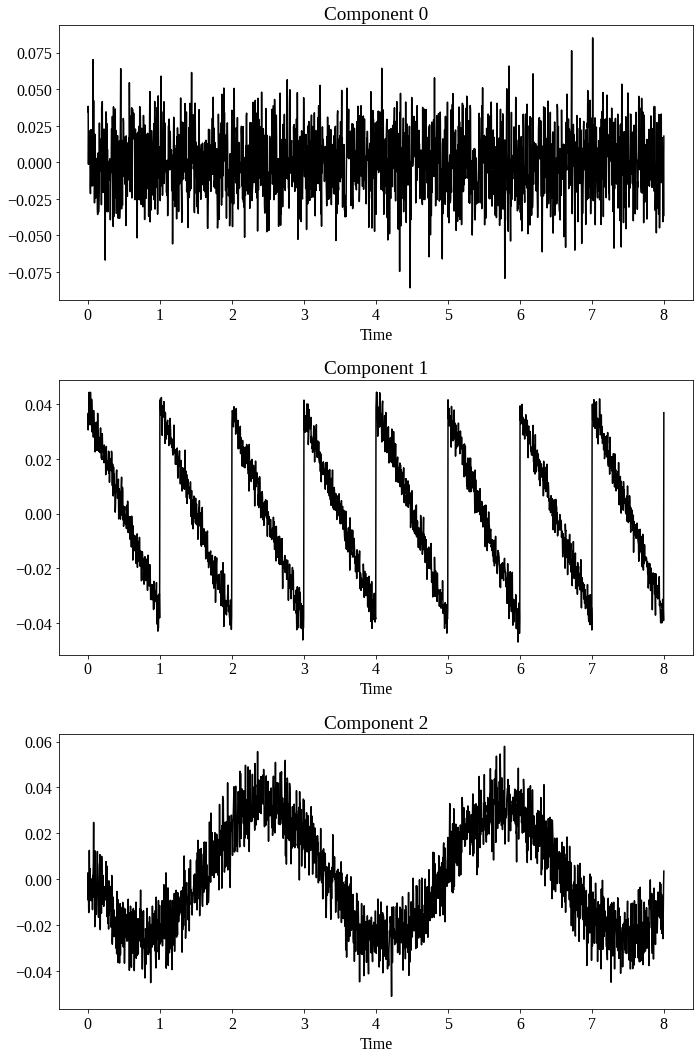

In [31]:
# Compute ICA
ica = FastICA(n_components=3, random_state=42)
X_ica = ica.fit_transform(X)  # Reconstruct signals

A_ = ica.mixing_  # Get estimated mixing matrix

fig, axs = plt.subplots(3, figsize=(10,15))

i = 0
for ax,s in zip(axs, X_ica.T):
    ax.plot(time,s, color='black')
    ax.set_xlabel('Time')
    ax.set_title('Component {:1.0f}'.format(i))
    i += 1

In [32]:
#find the optimal binwidth with cross-validation
y = (X_ica.T)[2]

bwrange = np.linspace(0.1, 4, 100) 
K = 5 # Do 5-fold cross validation
g = GaussianProcessRegressor(kernel = kernels.RBF(), random_state=0)
print(g.get_params().keys())
grid = GridSearchCV(g, {'kernel__length_scale': bwrange}, cv= K, verbose=2, n_jobs=-1) # Try each bandwidth with K-folds
grid.fit(time[:, np.newaxis], y) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['kernel__length_scale']
print('Optimal kernel bandwidth =', h_opt)

dict_keys(['alpha', 'copy_X_train', 'kernel__length_scale', 'kernel__length_scale_bounds', 'kernel', 'n_restarts_optimizer', 'normalize_y', 'optimizer', 'random_state'])
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [33]:
kernel = kernels.ConstantKernel(1, 'fixed')*kernels.RBF(h_opt, 'fixed')
gp = GaussianProcessRegressor(kernel=kernel, random_state=0)
gp.fit(time[:, np.newaxis], y)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=0.5), random_state=0)

In [34]:
x = np.linspace(0, 8, 1000)
ypred, ypred_err = gp.predict(x[:, np.newaxis], return_std=True)

/home/irene/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


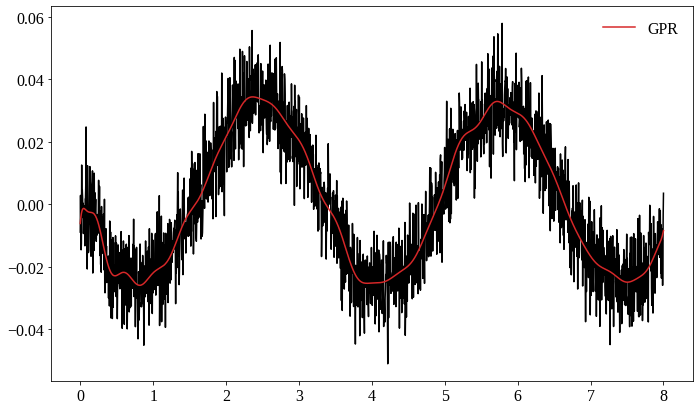

In [35]:
plt.plot(time, y, color = 'k')
plt.plot(x, ypred, color='tab:red', label='GPR')
plt.legend(frameon=False)

/home/irene/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


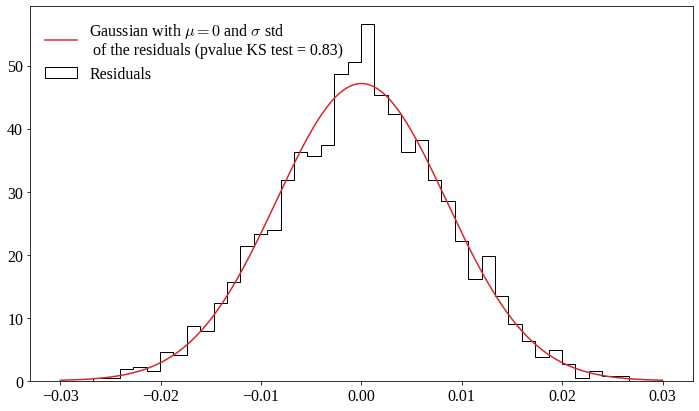

In [36]:
residuals = y - gp.predict(time[:, np.newaxis], return_std=True)[0]
plt.hist(residuals, bins = 40, histtype='step', color='k', density=True, label='Residuals');

sigma = np.std(residuals)
x_grid = np.linspace(-0.03, 0.03, 1000)
plt.plot(x_grid, scipy.stats.norm(loc = 0, scale = sigma).pdf(x_grid), color='tab:red', label = f'Gaussian with $\mu=0$ and $\sigma$ std \n of the residuals (pvalue KS test = {stats.normaltest(residuals)[0]:.2f})')
plt.legend(frameon=False, loc='upper left')

In [40]:
#model
def sinusoid(par, x):
    A = par[0]
    T = par[1]
    phi = par[2]
    offset = par[3]
    return offset + A*np.sin(2*np.pi*x/T - phi)

#loglikelihood
def LogLike(par, x, y, dy, model):
    ypred = model(par, x)
    return -0.5*np.sum((y-ypred)**2/dy**2 )

#logprior
A_min,A_max = 0, 0.1
T_min,T_max = 1, 5
phi_min,phi_max = -np.pi, np.pi
offset_min,offset_max = -0.01, 0.02

def prior_transform(u):
    par0 = np.array(u)  # copy u
    
    par0[0] = A_max*u[0] + A_min
    par0[1] = T_max*u[1] + T_min  
    par0[2] = phi_max*u[2] + phi_min
    par0[3] = offset_max*u[3] + offset_min
    
    return par0

import scipy
print(sigma)
dy = scipy.stats.norm(loc = 0, scale = sigma).rvs(len(time))

0.008460019218045086


In [41]:
sampler = dynesty.NestedSampler(LogLike, prior_transform, 4, logl_args=[time, y, sigma, sinusoid], nlive=100)
sampler.run_nested()
sresults = sampler.results

2257it [00:01, 1275.25it/s, +100 | bound: 47 | nc: 1 | ncall: 10733 | eff(%): 22.167 | loglstar:   -inf < -1035.235 <    inf | logz: -1055.452 +/-  0.427 | dlogz:  0.001 >  0.109]


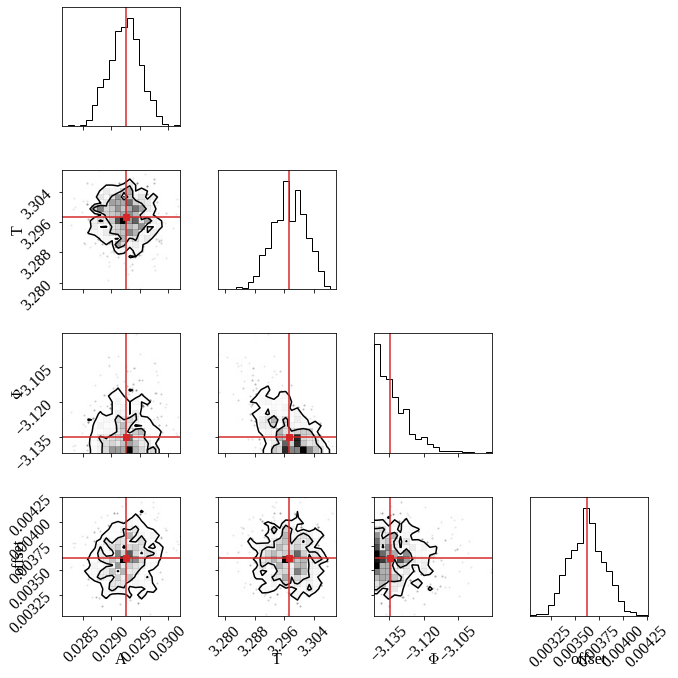

In [42]:
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights
samples_equal = dyfunc.resample_equal(samples, weights)

labels = ['A', 'T', r'$\Phi$', 'offset']

#compute median parameters
median_parameters = []
low_err = []
up_err = []
for i in range(4):
    low, med, up = np.percentile(samples_equal[:,i],[16,50, 84])
    median_parameters.append(med)
    low_err.append(med - low)
    up_err.append(up - med)
    
# Make the corner plot
figure = corner.corner(samples_equal, labels = labels, levels=[0.68,0.95], truths=median_parameters, truth_color='tab:red');

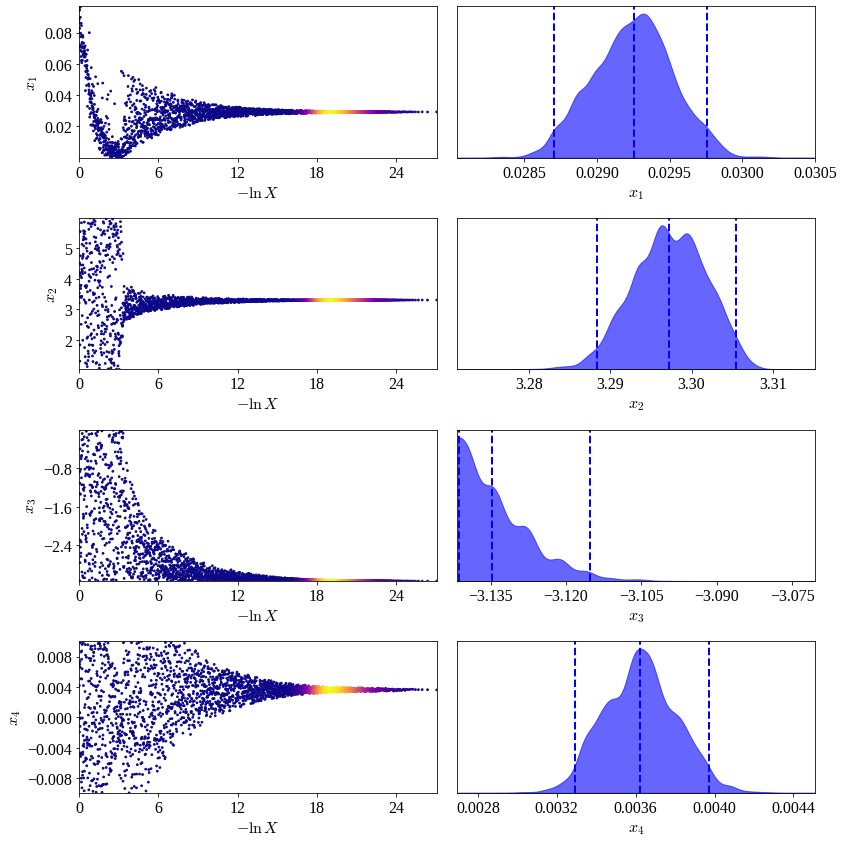

In [43]:
tfig, taxes = dyplot.traceplot(sresults)

Text(0.5, 0, 'Time')

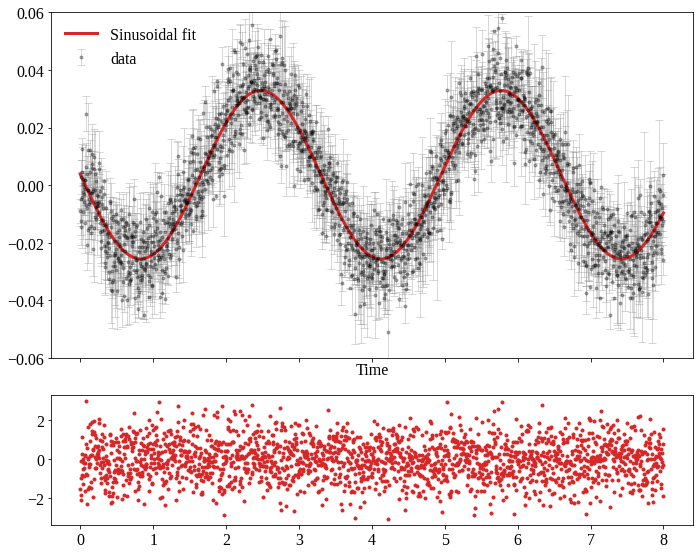

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(10,8), gridspec_kw={'height_ratios': [8, 3]})
ax[0].errorbar(time, y, yerr=dy, fmt='.k', ecolor='gray', lw=1,label='data', capsize = 4, alpha=0.3)
x = np.linspace(0, 8, 1000)
ypred = sinusoid(np.array(median_parameters), x)
ax[0].plot(x, ypred, color='tab:red', 
          label='Sinusoidal fit', lw=3)

#residuals
residuals = (y-sinusoid(np.array(median_parameters), time))/sigma
ax[1].scatter(time, residuals, marker='.', color='tab:red')

ax[0].legend(frameon=False)
ax[0].set_ylim([-0.06, 0.06])
ax[0].set_xlabel('Time')

In [50]:
print(f'Estimated period = {median_parameters[1]:.3f} + {up_err[1]:.3f} - {low_err[1]:.3f}')
print('sigma from true value:', (T_true - median_parameters[1])/up_err[1])

Estimated period = 3.297 + 0.005 - 0.004
sigma from true value: 0.6014503024490879


NormaltestResult(statistic=1.5799823567247402, pvalue=0.4538487989543397)


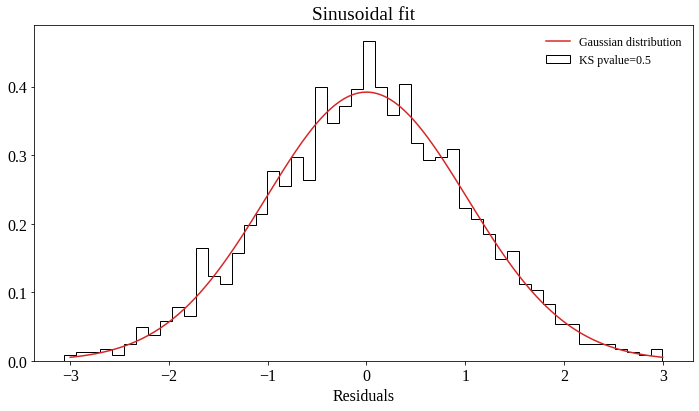

In [56]:
x = np.linspace(-3, 3, 1000)
plt.hist(residuals, bins=50, color='k', histtype='step', density=True, label='KS pvalue={:.1f}'.format(stats.normaltest(residuals).pvalue));
plt.plot(x, stats.norm(np.mean(residuals), np.std(residuals)).pdf(x), color='tab:red', label='Gaussian distribution')
plt.title(r'Sinusoidal fit')
plt.xlabel(r'Residuals')
plt.legend(frameon=False, fontsize=12)


print(stats.normaltest(residuals))

# Perform PCA

In [57]:
from sklearn.decomposition import PCA

n_components = 3
pca = PCA(n_components, svd_solver='auto')
pca_fit = pca.fit_transform(X)

(3, 3)


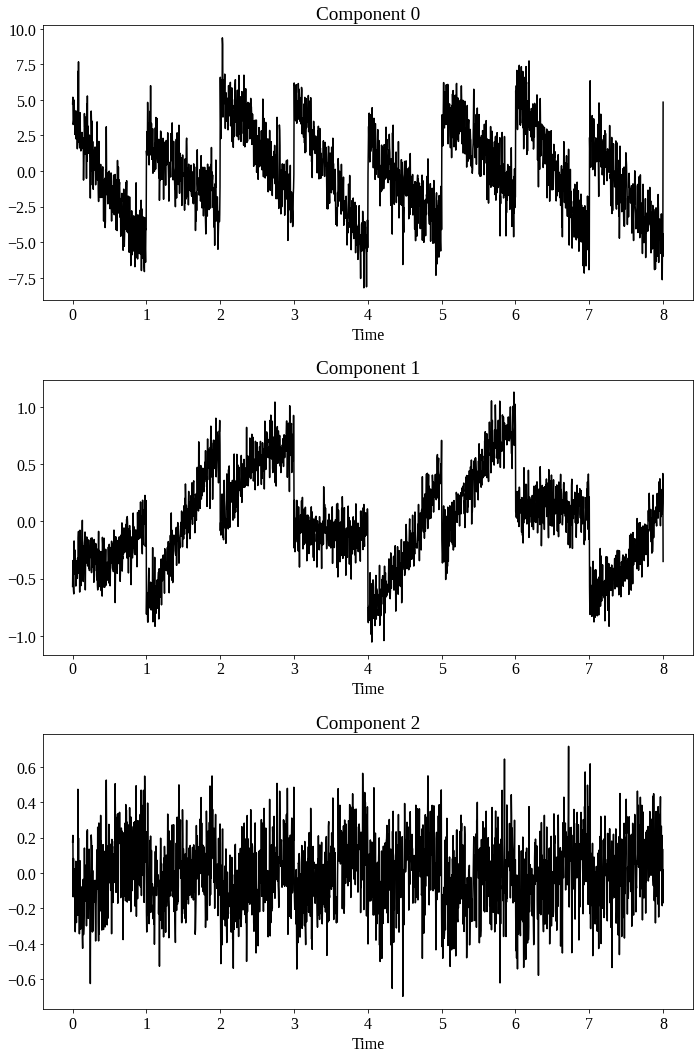

In [58]:
fig, axs = plt.subplots(3,figsize=(10,15))
print(pca.components_.shape)
i = 0
for ax,s in zip(axs,pca_fit.T):
    ax.plot(time,s, color='black')
    ax.set_xlabel('Time')
    ax.set_title('Component {:1.0f}'.format(i))
    i += 1

### Now try considering n_samples = 3 and the 2000 points of the time series as features

In [59]:
n_components = 3
pca = PCA(n_components, svd_solver='auto')
pca_fit = pca.fit(X.T)

(3, 2000)


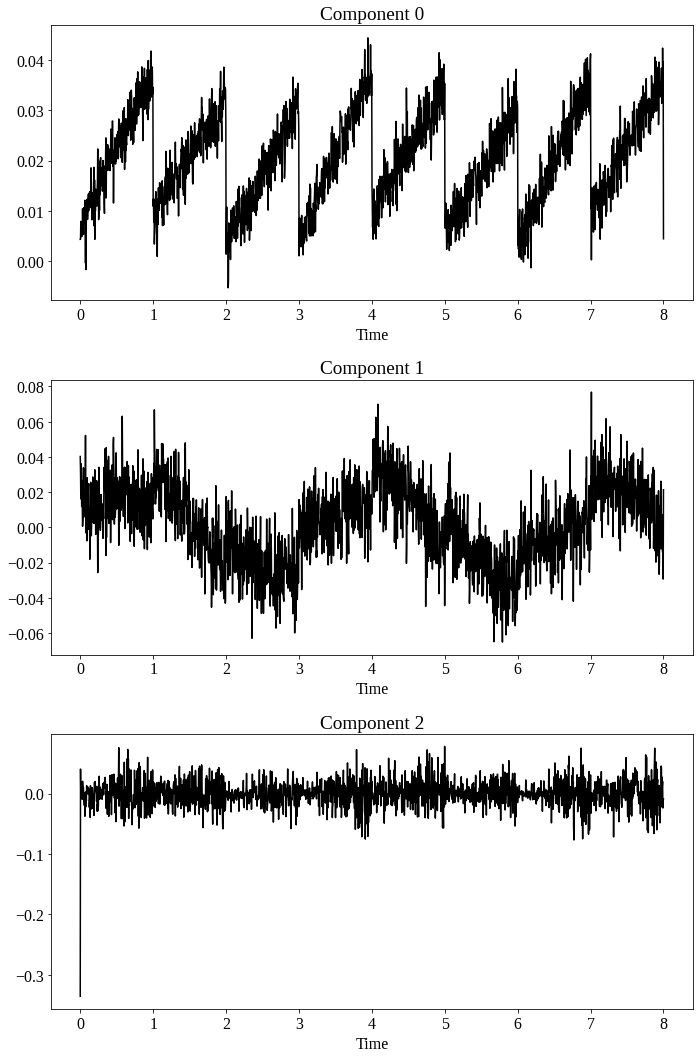

In [60]:
fig, axs = plt.subplots(3,figsize=(10,15))
print(pca.components_.shape)
i = 0
for ax,s in zip(axs,pca.components_):
    ax.plot(time,s, color='black')
    ax.set_xlabel('Time')
    ax.set_title('Component {:1.0f}'.format(i))
    i += 1

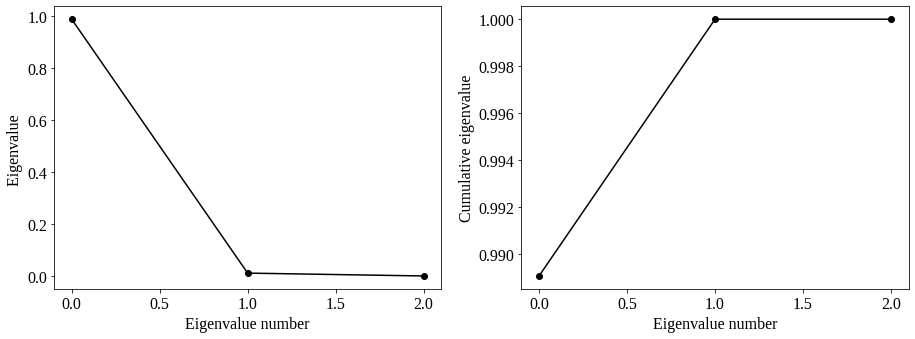

In [61]:
evals = pca.explained_variance_ratio_ 

# Plot the results
fig = plt.figure(figsize=(13, 5))

ax = fig.add_subplot(121)

ax.errorbar(np.arange(n_components), evals, color = 'k', fmt = '-o')
ax.set_xlabel("Eigenvalue number")
ax.set_ylabel("Eigenvalue ")

ax = fig.add_subplot(122)

ax.errorbar(np.arange(n_components), evals.cumsum(), color = 'k', fmt = '-o')
ax.set_xlabel("Eigenvalue number")
ax.set_ylabel("Cumulative eigenvalue")

plt.show()

In [62]:
y = pca.components_[1]

In [63]:
#find the optimal binwidth with cross-validation
bwrange = np.linspace(0.1, 4, 100) 
K = 5 # Do 5-fold cross validation
g = GaussianProcessRegressor(kernel = kernels.RBF(), random_state=0)
print(g.get_params().keys())
grid = GridSearchCV(g, {'kernel__length_scale': bwrange}, cv= K, verbose=2, n_jobs=-1) # Try each bandwidth with K-folds
grid.fit(time[:, np.newaxis], y) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['kernel__length_scale']
print('Optimal kernel bandwidth =', h_opt)

dict_keys(['alpha', 'copy_X_train', 'kernel__length_scale', 'kernel__length_scale_bounds', 'kernel', 'n_restarts_optimizer', 'normalize_y', 'optimizer', 'random_state'])
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [64]:
kernel = kernels.ConstantKernel(1, 'fixed')*kernels.RBF(h_opt, 'fixed')
gp = GaussianProcessRegressor(kernel=kernel, random_state=0)
gp.fit(time[:, np.newaxis], y)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=0.5), random_state=0)

In [65]:
x = np.linspace(0, 8, 1000)
ypred, ypred_err = gp.predict(x[:, np.newaxis], return_std=True)

/home/irene/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Text(0.5, 0, 'Time')

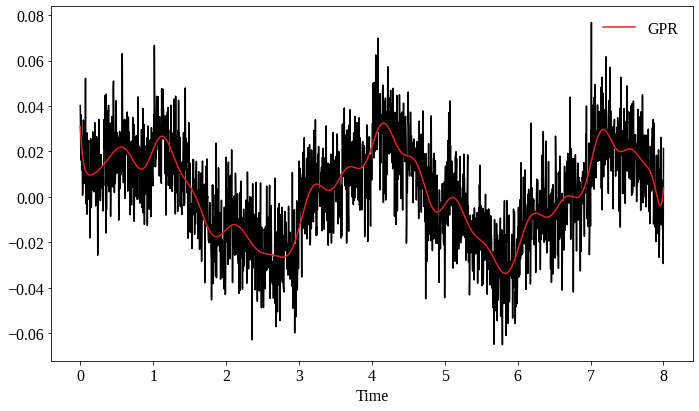

In [66]:
plt.plot(time, y, color = 'k')
plt.plot(x, ypred, color='tab:red', label='GPR')
plt.legend(frameon=False)
plt.xlabel('Time')

NormaltestResult(statistic=2.9247779364315996, pvalue=0.2316821318293107)


/home/irene/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


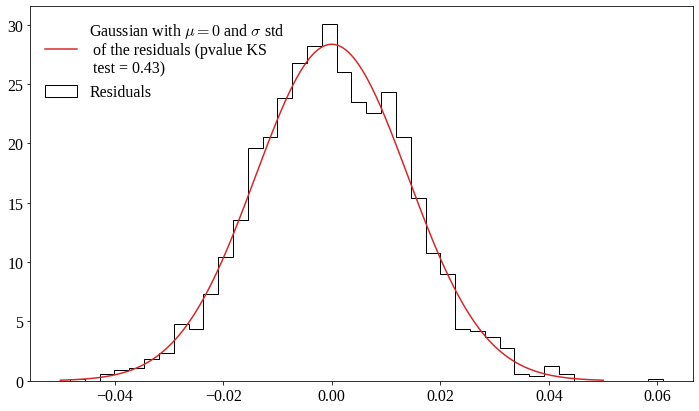

In [67]:
residuals = y - gp.predict(time[:, np.newaxis], return_std=True)[0]
plt.hist(residuals, bins = 40, histtype='step', color='k', density=True, label='Residuals');
print(stats.normaltest(residuals))

sigma = np.std(residuals)
x_grid = np.linspace(-0.05, 0.05, 1000)
plt.plot(x_grid, scipy.stats.norm(loc = 0, scale = sigma).pdf(x_grid), color='tab:red', label = 'Gaussian with $\mu=0$ and $\sigma$ std \n of the residuals (pvalue KS \n test = 0.43)')
plt.legend(frameon=False, loc='upper left')

In [68]:
A_min, A_max = 0, 0.04
phi_min, phi_max = -np.pi, np.pi
offset_min, offset_max = -0.001, 0.002
sampler = dynesty.NestedSampler(LogLike, prior_transform, 4, logl_args=[time, y, sigma, sinusoid], nlive=100)
sampler.run_nested()
sresults = sampler.results

1654it [00:01, 1468.87it/s, +100 | bound: 28 | nc: 1 | ncall: 7968 | eff(%): 22.293 | loglstar:   -inf < -1165.973 <    inf | logz: -1180.187 +/-  0.353 | dlogz:  0.001 >  0.109]


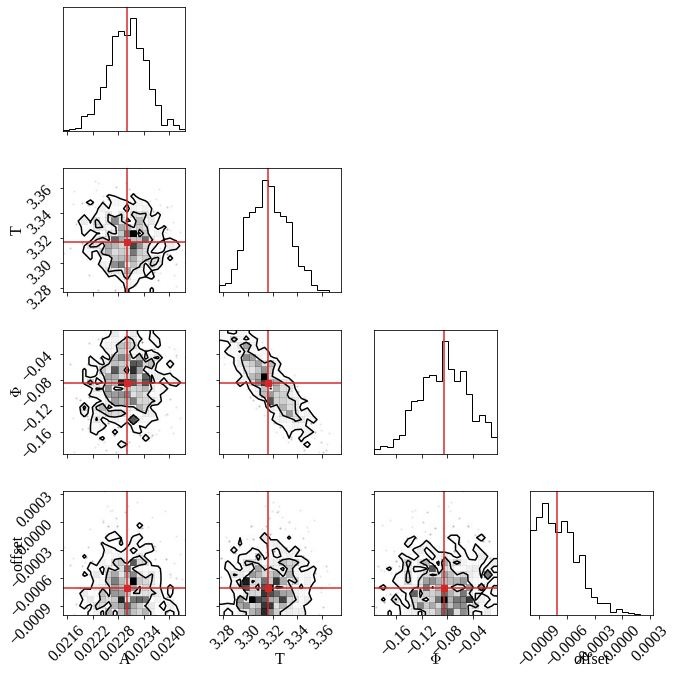

In [69]:
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights
samples_equal = dyfunc.resample_equal(samples, weights)

labels = ['A', 'T', r'$\Phi$', 'offset']

#compute median parameters
median_parameters = []
low_err = []
up_err = []
for i in range(4):
    low, med, up = np.percentile(samples_equal[:,i],[16,50, 84])
    median_parameters.append(med)
    low_err.append(med - low)
    up_err.append(up - med)
    
# Make the corner plot
figure = corner.corner(samples_equal, labels = labels, levels=[0.68,0.95], truths=median_parameters, truth_color='tab:red');

Text(0.5, 0, 'Time')

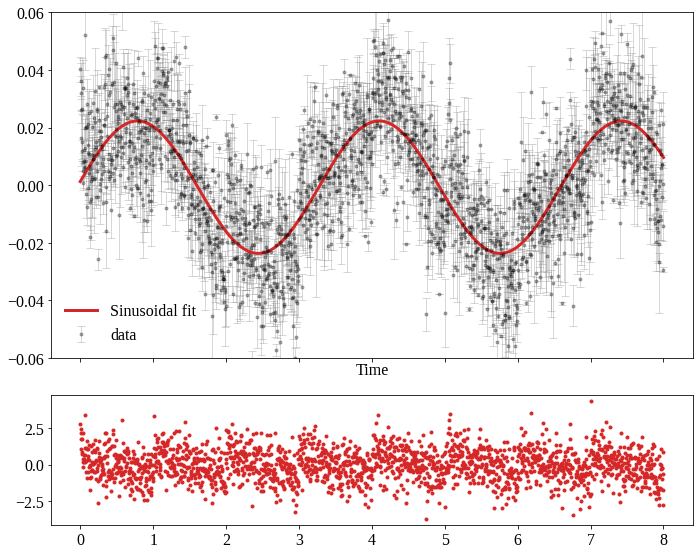

In [70]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(10,8), gridspec_kw={'height_ratios': [8, 3]})
ax[0].errorbar(time, y, yerr=dy, fmt='.k', ecolor='gray', lw=1,label='data', capsize = 4, alpha=0.3)
x = np.linspace(0, 8, 1000)
ypred = sinusoid(np.array(median_parameters), x)
ax[0].plot(x, ypred, color='tab:red', 
          label='Sinusoidal fit', lw=3)

#residuals
residuals = (y-sinusoid(np.array(median_parameters), time))/sigma
ax[1].scatter(time, residuals, marker='.', color='tab:red')

ax[0].legend(frameon=False)
ax[0].set_ylim([-0.06, 0.06])
ax[0].set_xlabel('Time')

In [76]:
print(f'Estimated period = {median_parameters[1]:.3f} + {up_err[1]:.3f} - {low_err[1]:.3f}')
print(f'sigma from true value:{(T_true - median_parameters[1])/up_err[1]:.3f}')

Estimated period = 3.316 + 0.016 - 0.016
sigma from true value:-0.986
